Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5565 - loss: 0.8723
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6470 - loss: 0.7437
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6393 - loss: 0.7319
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6415 - loss: 0.7170
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6486 - loss: 0.7104
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6518 - loss: 0.7047
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6637 - loss: 0.6770
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6676 - loss: 0.6715
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6966 - loss: 0.6483
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6838 - loss: 0.6444
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7090 - loss: 0.6132
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

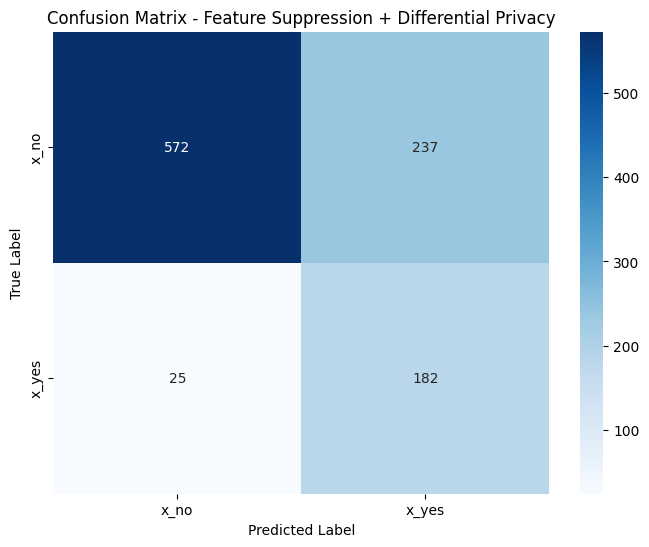


Defense Mechanism: Gradient Regularization
Inversion Model Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

        x_no       0.97      0.72      0.83       809
       x_yes       0.45      0.91      0.61       207

    accuracy                           0.76      1016
   macro avg       0.71      0.81      0.72      1016
weighted avg       0.86      0.76      0.78      1016



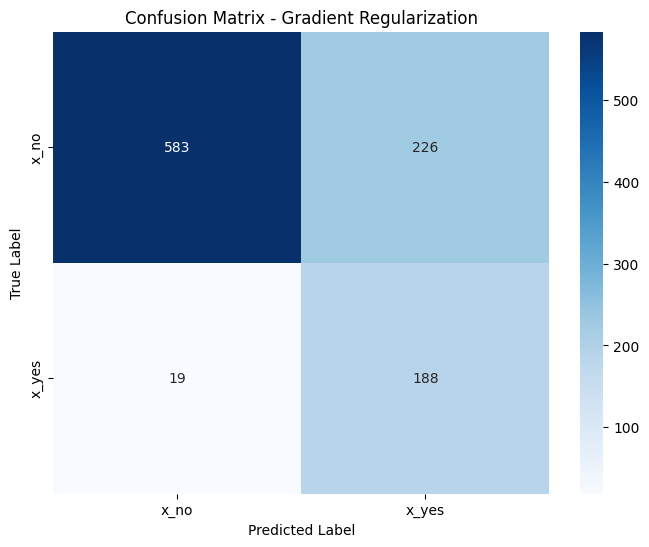

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=1.0):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def apply_adversarial_training(X_train, y_train, epsilon=0.01):
    X_adv = X_train + epsilon * np.sign(np.random.randn(*X_train.shape))
    return np.vstack([X_train, X_adv]), np.vstack([y_train, y_train])

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def regularized_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.1 * entropy_penalty

def train_target_model(X_train, y_train, loss_function='categorical_crossentropy'):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_function,
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)
    return inversion_model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=1.0)

target_model_suppressed_dp = train_target_model(X_train_suppressed_dp, y_train)
target_model_reg = train_target_model(X_train, y_train, loss_function=regularized_loss)

# Train inversion models
inversion_model_suppressed_dp = train_inversion_model(target_model_suppressed_dp, X_test, sensitive_test)
inversion_model_reg = train_inversion_model(target_model_reg, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy": evaluate_inversion_model(inversion_model_suppressed_dp, X_test, sensitive_test, target_model_suppressed_dp),
    "Gradient Regularization": evaluate_inversion_model(inversion_model_reg, X_test, sensitive_test, target_model_reg)
}

# Display results
display_results(results)

**Add more noise by by setting epsilon = 0.5 instead of 1.0**

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5485 - loss: 2.4017
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5670 - loss: 0.9164
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6197 - loss: 0.7955
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6086 - loss: 0.7691
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6255 - loss: 0.7438
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6389 - loss: 0.7332
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 0.7341
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6520 - loss: 0.7081
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6465 - loss: 0.7242
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6486 - loss: 0.7070
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6576 - loss: 0.6933
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

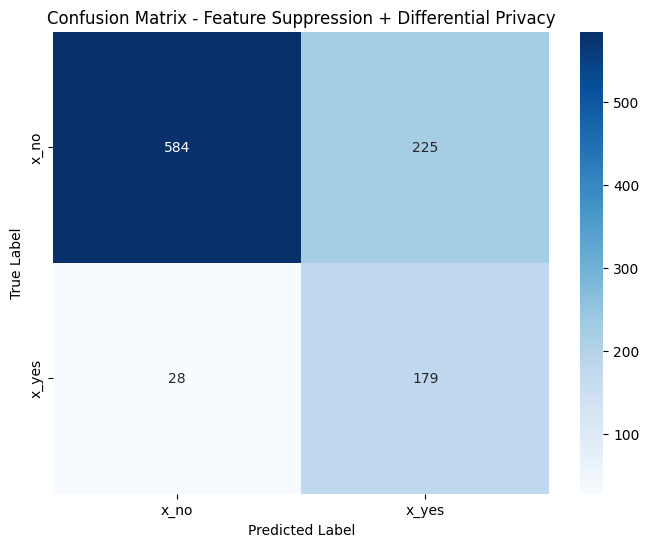


Defense Mechanism: Gradient Regularization
Inversion Model Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

        x_no       0.95      0.73      0.83       809
       x_yes       0.45      0.86      0.60       207

    accuracy                           0.76      1016
   macro avg       0.70      0.80      0.71      1016
weighted avg       0.85      0.76      0.78      1016



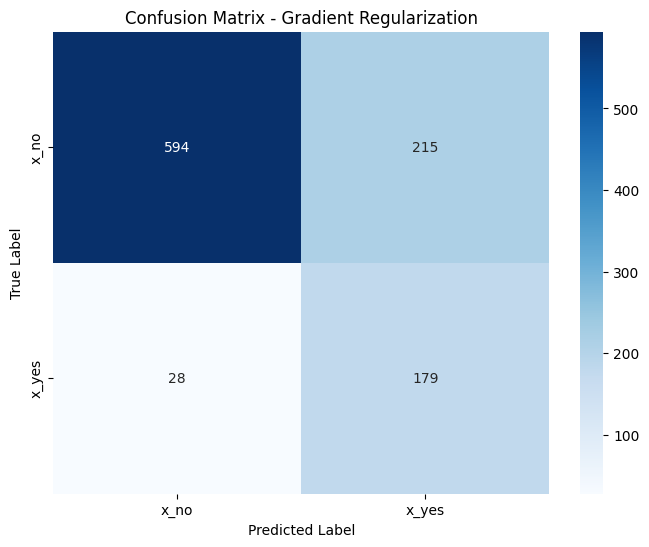

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def apply_adversarial_training(X_train, y_train, epsilon=0.01):
    X_adv = X_train + epsilon * np.sign(np.random.randn(*X_train.shape))
    return np.vstack([X_train, X_adv]), np.vstack([y_train, y_train])

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def regularized_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.1 * entropy_penalty

def train_target_model(X_train, y_train, loss_function='categorical_crossentropy'):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_function,
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)
    return inversion_model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    def mask_confidences(y_pred, bins=10):
        return tf.round(y_pred * bins) / bins  # Round probabilities to nearest 0.1

    predicted_probabilities = target_model.predict(X_test)
    predicted_probabilities = mask_confidences(predicted_probabilities)  # Apply confidence masking
    X_inversion = np.hstack((X_test, predicted_probabilities))
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=0.1)

target_model_suppressed_dp = train_target_model(X_train_suppressed_dp, y_train)
target_model_reg = train_target_model(X_train, y_train, loss_function=regularized_loss)

# Train inversion models
inversion_model_suppressed_dp = train_inversion_model(target_model_suppressed_dp, X_test, sensitive_test)
inversion_model_reg = train_inversion_model(target_model_reg, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy": evaluate_inversion_model(inversion_model_suppressed_dp, X_test, sensitive_test, target_model_suppressed_dp),
    "Gradient Regularization": evaluate_inversion_model(inversion_model_reg, X_test, sensitive_test, target_model_reg)
}

# Display results
display_results(results)
